# Genetic Algorithm (Permutation Flow Shop Problem)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from tqdm import tqdm

In [2]:
class Chromosome:
    def __init__(self, perm) -> None:
        self.perm = perm
        self.cost = None

    def __repr__(self) -> str:
        return f'Node(perm={self.perm}, cost={self.cost})'

    def __lt__(self, other):
        return self.cost < other.cost

## Getting data

In [3]:
with open('ta80','r',encoding = 'utf-8') as f:
   n, m = [int(x) for x in f.readline().split()]
   data = []
   for i in range(n):
       data.append([int(x) for x in f.readline().split()])

data = np.array(data)
data.shape

(100, 40)

## Objective function

![](https://i.imgur.com/saRstYp.png)

In [4]:
def objective(perm, data):
    n_jobs, n_machines = data.shape

    # helper array, it stores the completion time for each machine for last job 
    jcx = np.zeros(n_machines)

    # filling in end times for each machine for first job
    end = 0
    for j in range(n_machines):
        end += data[perm[0]][j]
        jcx[j] = end
    # print(jcx)

    # filling in end times for each machine for second to last job
    for i in range(1,n_jobs):
        for j in range(n_machines):
            if j == 0:  # if first machine in job
                jcx[j] = jcx[j] + data[perm[i]][j]
            else:       # else, consider previous end time of last machine in current job, jcx[j-1]
                        # and end time of current machine in last job,  jcx[j]
                jcx[j] = max(jcx[j-1], jcx[j]) + data[perm[i]][j]
    # print(jcx)
    
    return jcx[n_machines - 1]

objective(list(range(data.shape[0])), data)

7730.0

## Initialization

In [5]:
def initialization(m, n):
    # m -> no of chromosomes
    # n -> no of genes in chromosome
    pop = [Chromosome(np.random.permutation(n)) for i in range(m)]
    for c in pop:
        c.cost = objective(c.perm, data)
    return pop

# testing
# initialization(2, 5)

## Selection

In [6]:
def selection(pop):
    wts = [chr.cost for chr in pop]
    # print(wts)
    wts = wts - (min(wts)-1) # shifting so min value becomes 1
    wts = 1 / wts # minimization problem
    wts = wts / sum(wts) # scaling to probability values
    # print(wts)

    # two indices between [0,len(pop)-1] without replacement
    ixs = np.random.choice(len(pop), 2, p=wts, replace=False) 

    # return pop[ixs[0]], pop[ixs[1]] # these get modified later, so make deep copies
    return copy.deepcopy(pop[ixs[0]]), copy.deepcopy(pop[ixs[1]])

# testing
# selection(initialization(5, 5))

## Crossover

In [7]:
def crossover(parent1, parent2, p_c, p_i):
    n = len(parent1.perm)
    # k = int(np.sqrt(n))
    k = int(n * p_i)
    si = np.random.choice(np.arange(1,n), k, replace=False) # selected indices
    se = set(parent1.perm[si]) # selected elements
    # print(si)
    # print(se)

    order_p1 = []
    order_p2 = []
    for x in parent1.perm:
        if x in se:
            order_p1.append(x)
    for x in parent2.perm:
        if x in se:
            order_p2.append(x)
    # print(order_p1)
    # print(order_p2)

    child1_perm = parent1.perm.copy()
    child2_perm = parent2.perm.copy()
    for i in range(n):
        if child1_perm[i] in se:
            child1_perm[i] = order_p2[0]
            order_p2.pop(0)
    for i in range(n):
        if child2_perm[i] in se:
            child2_perm[i] = order_p1[0]
            order_p1.pop(0)

    # print(child1_perm)
    # print(child2_perm)
    child1 = Chromosome(child1_perm)
    child2 = Chromosome(child2_perm)

    p1 = np.random.rand()
    p2 = np.random.rand()
    return (child1 if p1 < p_c else parent1, child2 if p2 < p_c else parent2)
    
# testing
# _sel = selection(initialization(5, 5))
# print(_sel)
# crossover(_sel[0], _sel[1], p_c=1)

## Mutation

In [8]:
def mutation(child, p_m, p_i):
    n = len(child.perm)
    k = int(n * p_i)
    # k = int(np.sqrt(n))
    si = np.random.choice(np.arange(1,n), k, replace=False) # selected indices
    se = set(child.perm[si]) # selected elements
    # print(si)
    # print(se)

    order = []
    for x in child.perm:
        if x in se:
            order.append(x)
    order = list(np.random.permutation(order))
    # print(order)

    child_perm = child.perm.copy()
    for i in range(n):
        if child_perm[i] in se:
            child_perm[i] = order[0]
            order.pop(0)
    # print(child_perm)

    child_m = Chromosome(child_perm)

    p = np.random.rand()
    return child_m if p < p_m else child

# testing
# _pop = initialization(1, 5)
# print(_pop)
# mutation(_pop[0], p_m=0.1)

## Elitism

In [9]:
def elitism(pop, new_pop, e_r):
    m = len(pop)
    ec = int(e_r * m) # elites count
    # print(ec)
    pop.sort()
    # pop.sort(reverse=True)
    new_pop.sort(reverse=True)
    # new_pop.sort()
    new_pop[:ec] = pop[:ec]
    return new_pop

## Main Genetic Algorithm function

In [10]:
def genetic_algorithm(m, n, max_gens, p_c, p_m, e_r, p_i):
    cost_list = []
    pop = initialization(m, n)

    for g in tqdm(range(max_gens)):

        new_pop = []

        for i in range(m//2):
            # print(i, pop)
            parent1, parent2 = selection(pop)
            child1, child2 = crossover(parent1, parent2, p_c, p_i)
            child1 = mutation(child1, p_m, p_i)
            child2 = mutation(child2, p_m, p_i)

            new_pop.append(child1)
            new_pop.append(child2)

        for c in new_pop:
            c.cost = objective(c.perm, data)

        pop = elitism(pop, new_pop, e_r)
        # print(min(pop))
        cost_list.append(min(pop).cost)
    
    plt.plot(cost_list)
    return min(pop)

In [11]:
# genetic_algorithm(m = 50, n = 100, max_gens = 500, p_c = 0.1, p_m = 0.9, e_r = 0.1, p_i = 0.1)

In [12]:
# genetic_algorithm(m = 50, n = 100, max_gens = 500, p_c = 0.9, p_m = 0.1, e_r = 0.1, p_i = 0.1)

In [13]:
# genetic_algorithm(m = 50, n = 100, max_gens = 500, p_c = 0.1, p_m = 0.1, e_r = 0.1, p_i = 0.1)

In [14]:
# genetic_algorithm(m = 50, n = 100, max_gens = 500, p_c = 0.9, p_m = 0.9, e_r = 0.1, p_i = 0.1)

100%|██████████| 500/500 [01:40<00:00,  4.98it/s]


Node(perm=[37 47 62 45  4 95 41 27 33 29 11  7 50 88 83 97 75 57 89 16 39 87 53 65
 26  9 22 34 35 68 48 91 19 15 74 80 59 14 43 73 28 20 52 42 44 21 79 66
 86 69 46  0 72 30 96 98 55 17  8 49 51 23 56 60 67 13 64 32 85 92 81 70
 78 24  5  3  2 58 54 94 90 31 99 18 38 25 77  6 82 71 61 36 10 84 40 93
 76 12  1 63], cost=6691.0)

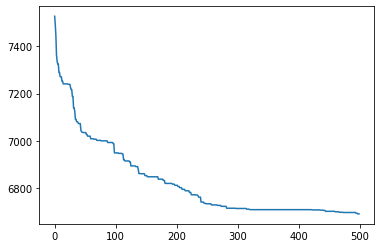

In [16]:
genetic_algorithm(m = 50, n = 100, max_gens = 500, p_c = 0.9, p_m = 0.9, e_r = 0.1, p_i = 0.02)